# **Bike Sharing System**

# 1. Install Libraries 

In [ ]:
import os
from os import listdir, makedirs, remove
import os.path as osp
import pandas as pd
from datetime import datetime, timedelta
import itertools
import numpy as np
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Data Preparation

In [2]:
interval = 30

In [3]:
# Loading datasets obtained from pre-processing stage.
tinterval_df = pd.read_csv("/content/drive/My Drive/data_int_{}/tinterval.csv".format(interval))
data_df= pd.read_csv("/content/drive/My Drive/data_int_{}/metro_formated_data.csv".format(interval))

In [4]:
data_df.head()

,time_id,station_id,docks_demand,bikes_demand
0,288,3000,0,0
1,289,3000,0,0
2,290,3000,0,0
3,291,3000,0,0
4,292,3000,0,0


In [5]:
#Joining both dataframes
time_df = data_df.merge(tinterval_df, how= 'left', left_on='time_id', right_on= 'interval_id')
time_df = time_df.drop(columns= ['time_id', 'Unnamed: 0','interval_id','outer_limit'])
time_df = time_df.rename(columns={'inner_limit' : 'date_time'})
time_df = time_df[['date_time', 'station_id', 'docks_demand', 'bikes_demand']]
time_df['date_time'] = pd.to_datetime(time_df['date_time'])

In [6]:
data_df.head()

,time_id,station_id,docks_demand,bikes_demand
0,288,3000,0,0
1,289,3000,0,0
2,290,3000,0,0
3,291,3000,0,0
4,292,3000,0,0


In [7]:
#Removing Virtual Station and Fake Stations from Data
print(time_df.shape)
time_df = time_df[time_df.station_id != 3000]
time_df = time_df[time_df.station_id != 4285]
time_df = time_df[time_df.station_id != 4286]

(9959520, 4)


In [8]:
# Sorting and reindexing columns
time_df =time_df.sort_values(by ='date_time')

In [9]:
#One station
df_3005 = time_df[time_df.station_id == 3005]

In [10]:
# Obtain values for station 3005's bike and docks demand separately.
df_3005 = time_df[time_df.station_id == 3005]
df_3005_bike = df_3005[['date_time', 'bikes_demand']]
df_3005_docks = df_3005[['date_time', 'docks_demand']]
df_3005_bike.set_index('date_time', inplace=True)
df_3005_docks.set_index('date_time', inplace=True)
print(df_3005_bike.head(2))
print(df_3005_docks.head(2))


                     bikes_demand
date_time                        
2019-01-01 00:00:00             0
2019-01-01 00:30:00             0
                     docks_demand
date_time                        
2019-01-01 00:00:00             0
2019-01-01 00:30:00             0


Confirming conditions of time series data before applying the dataset

In [11]:
def test_stationarity(timeseries):
  #determining rolling statistics
  movingAverage = timeseries.rolling(window = 4).mean()
  movingStd = timeseries.rolling(window = 4).std()
  
  #Plot rolling statistics
  orig = plt.plot(timeseries, color = 'blue', label ='Original')
  mean = plt.plot(movingAverage, color = 'red', label= 'Rolling Mean')
  std = plt.plot(movingStd, color = 'black', label= 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  #Perform Dickey-Fuller test:
  print('Results of Dickey-Fullet Test:')
  dftest = adfuller(timeseries['bikes_demand'], autolag = 'AIC')

  dfoutput = pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', '#Lag Used', 'Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

  print(dfoutput)

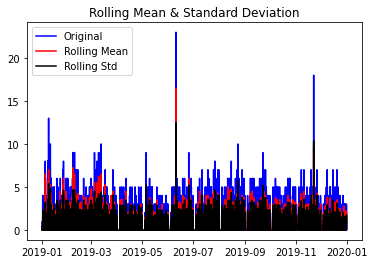

Results of Dickey-Fullet Test:
Test Statistic                   -30.915157
p-value                            0.000000
#Lag Used                         23.000000
Number of Observations Used    61224.000000
Critical Value (1%)               -3.430457
Critical Value (5%)               -2.861587
Critical Value (10%)              -2.566795
dtype: float64


In [12]:
test_stationarity(df_3005_bike)

Since p-value is less than 0.5 data is stationary

In [ ]:
# execute this cell only if df_3005_bike p value is more than 0.5
#and df_3005_bike_diff p value is less than 0.5
df_3005_bike.shift(1)
df_3005_dock_diff = df_3005_docks.diff(periods=1)
df_3005_dock_diff = df_3005_dock_diff[1:]
df_3005_dock_diff.head()
df_3005_bike_diff.plot()
test_stationarity(df_3005_bike_diff)
df_3005_bike = df_3005_bike_diff

Train and Test data

In [14]:
X = df_3005_bike.values
split = int(len(X)*0.8)
train = X[0:split]
test = X[split:]
predictions = []


In [15]:
#Identifying ideal parameter value of p,d and q with lowest AIC value

df_aic = pd.DataFrame(columns = ['Parameters', 'AIC'])   
param_list =[]
aic_list=[]
p=q=range(0,5)
d=range(1,2)
pdq = list(itertools.product(p,d,q))
for param in pdq:
  try:
    model_arima = ARIMA(train,order=param)
    model_arima_fit = model_arima.fit()
    param_list.append(param)
    aic_list.append(model_arima_fit.aic)
    print(param,model_arima_fit.aic)
  except:
    continue
df_aic['Parameters'] = param_list
df_aic['AIC'] = aic_list

(0, 1, 0) 157429.31388219254
(0, 1, 1) 133976.7752558983
(0, 1, 2) 133778.38668290476
(1, 1, 0) 144515.89374081878
(1, 1, 1) 133741.7314817912
(1, 1, 2) 132992.53075331246
(1, 1, 3) 132949.4215652671
(1, 1, 4) 133494.1182688598
(2, 1, 0) 140729.9192449045
(2, 1, 1) 133513.72790383597
(2, 1, 2) 133536.94174415752
(2, 1, 3) 132924.6938428773
(2, 1, 4) 132804.4371608915
(3, 1, 0) 138015.6239298381
(3, 1, 1) 133508.76510889461
(3, 1, 2) 133452.71469493432
(3, 1, 3) 132796.17496435242
(3, 1, 4) 132771.97636728347
(4, 1, 0) 136930.63516407183
(4, 1, 1) 133397.80706570865
(4, 1, 2) 133407.2857175292
(4, 1, 3) 132855.2039445796
(4, 1, 4) 132787.20986763082


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [16]:
#Training the Model
model_arima = ARIMA(train, order= df_aic.Parameters[df_aic.AIC.idxmin()])
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)
print(df_aic.Parameters[df_aic.AIC.idxmin()])

132771.97636728347
(3, 1, 4)


In [17]:
# Prediction for test set
predictions= model_arima_fit.forecast(steps=len(test))[0]
print(len(predictions))

12250


Evaluation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


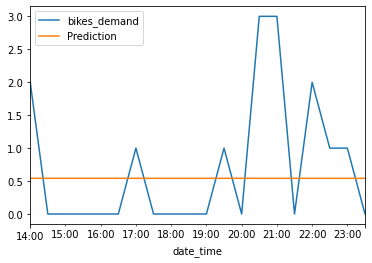

In [18]:
df_eval = df_3005_bike[split:]
df_eval['Prediction'] = predictions
df_eval.tail(20).plot()

In [19]:
#Evaluation
print('Evaluation')
print( "Mean Squareed Error: ", mean_squared_error(test,predictions))
print("Mean Absolute Error: ", mean_absolute_error(test,predictions))
print( "Root Mean Square Error: ", np.sqrt(mean_squared_error(test,predictions)))

Evaluation
Mean Squareed Error:  1.124096849127318
Mean Absolute Error:  0.7854960149318593
Root Mean Square Error:  1.0602343368931786


## Docks Availability Model -Prediction

In [20]:
def test_stationarity(timeseries):
  #determining rolling statistics
  movingAverage = timeseries.rolling(window = 4).mean()
  movingStd = timeseries.rolling(window = 4).std()

  #Plot rolling statistics
  orig = plt.plot(timeseries, color = 'blue', label ='Original')
  mean = plt.plot(movingAverage, color = 'red', label= 'Rolling Mean')
  std = plt.plot(movingStd, color = 'black', label= 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)

  #Perform Dickey-Fuller test:
  print('Results of Dickey-Fullet Test:')
  dftest = adfuller(timeseries['docks_demand'], autolag = 'AIC')

  dfoutput = pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', '#Lag Used', 'Number of Observations Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

  print(dfoutput)

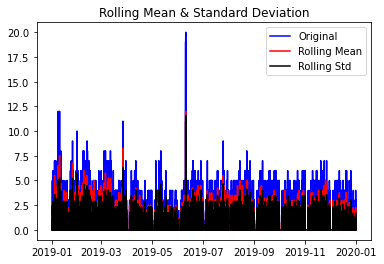

Results of Dickey-Fullet Test:
Test Statistic                   -25.999766
p-value                            0.000000
#Lag Used                         60.000000
Number of Observations Used    61187.000000
Critical Value (1%)               -3.430457
Critical Value (5%)               -2.861587
Critical Value (10%)              -2.566795
dtype: float64


In [21]:
test_stationarity(df_3005_docks)

In [50]:
# execute this cell only if df_3005_docks p value is more than 0.5
#and df_3005_dock_diff p value is less than 0.5
df_3005_docks.shift(1)
df_3005_dock_diff = df_3005_docks.diff(periods=1)
df_3005_dock_diff = df_3005_dock_diff[1:]
df_3005_dock_diff.head()
df_3005_dock_diff.plot()
test_stationarity(df_3005_dock_diff)
df_3005_dock = df_3005_dock_diff

,docks_demand
date_time,
2019-01-01 01:00:00,1.0
2019-01-01 02:00:00,0.0
2019-01-01 03:00:00,-1.0
2019-01-01 04:00:00,0.0
2019-01-01 05:00:00,0.0


In [22]:
X = df_3005_docks.values
split = int(len(X)*0.8)
train = X[0:split]
test = X[split:]
predictions = []


In [23]:
df_aic = pd.DataFrame(columns = ['Parameters', 'AIC'])   
param_list =[]
aic_list=[]

p=q=range(0,5)
d=range(1,2)
pdq = list(itertools.product(p,d,q))
for param in pdq:
  try:
    model_arima = ARIMA(train,order=param)
    model_arima_fit = model_arima.fit()
    param_list.append(param)
    aic_list.append(model_arima_fit.aic)
    print(param,model_arima_fit.aic)
  except:
    continue
df_aic['Parameters'] = param_list
df_aic['AIC'] = aic_list

(0, 1, 0) 160244.25812685117
(0, 1, 1) 137032.20695337234
(0, 1, 2) 136817.02966167548
(1, 1, 0) 146651.4568294415
(1, 1, 1) 136753.11148939727
(1, 1, 2) 136946.19478148592
(1, 1, 3) 135768.2695388402
(1, 1, 4) 136261.61255301075
(2, 1, 0) 143301.2384261181
(2, 1, 1) 136223.5927566568
(2, 1, 2) 135766.582082741
(2, 1, 3) 135630.4339504414


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


(2, 1, 4) 135565.22332939308
(3, 1, 0) 140880.44234412623
(3, 1, 1) 136205.93313647088
(3, 1, 2) 136150.32838417255
(3, 1, 3) 135552.37968673473


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(3, 1, 4) 135629.89307426062
(4, 1, 0) 139822.96101049375
(4, 1, 1) 136083.91342158703
(4, 1, 2) 136080.99890580526


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(4, 1, 3) 135586.79605327573
(4, 1, 4) 135473.82647274155


In [24]:
model_arima = ARIMA(train,order=df_aic.Parameters[df_aic.AIC.idxmin()])
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)
print(df_aic.Parameters[df_aic.AIC.idxmin()])

135473.82647274155
(4, 1, 4)


In [25]:
predictions= model_arima_fit.forecast(steps=len(test))[0]
#print(predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


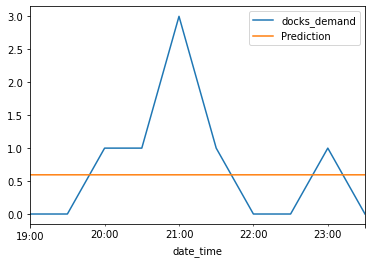

In [26]:
#Plot  
df_eval_docks = df_3005_docks[split:]
df_eval_docks['Prediction'] = predictions
df_eval_docks.tail(10).plot()

In [27]:
#Evaluation
print('Evaluation')
print( "Mean Squareed Error: ", mean_squared_error(test,predictions))
print("Mean Absolute Error: ", mean_absolute_error(test,predictions))
print( "Root Mean Square Error: ", np.sqrt(mean_squared_error(test,predictions)))

Evaluation
Mean Squareed Error:  1.1657842058696066
Mean Absolute Error:  0.8238545746527919
Root Mean Square Error:  1.0797148724869945
